In [343]:
#####Hierarchical Geographical Modeling of User Locationsfrom Social Media Posts#####
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import scipy
from scipy import stats
from scipy import special
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *

#np.random.seed(98537)

In [344]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    if pattern==1:
        z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [345]:
####データの生成####
##データの設定
levels = 2
k1 = 5
k2 = np.array([4, 4, 5, 5, 6])
topic = 15
hh = 3000
v = 1000   #語彙数
Lambda = np.random.gamma(12.5, 1/0.25, hh)
pt = np.random.poisson(Lambda, hh); pt[pt < 10] = 10
N = np.sum(pt)
w = np.random.poisson(np.random.gamma(10.0, 1/0.5, N)); w[w < 5] = 5
f = np.sum(w)

In [346]:
##IDとインデックスを作成
#IDを作成
u_id = np.repeat(np.arange(hh), pt)
d_id = np.repeat(np.arange(N), w)

#インデックスを作成
u_list = [i for i in range(hh)]
d_list = [i for i in range(N)]
for i in range(hh):
    u_list[i] = np.array(np.where(u_id==i)[0], dtype="int")
for i in range(N):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [367]:
####パラメータとデータの生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##ノード分布を生成
    #グローバルノード分布を生成
    G1 = np.random.dirichlet(np.repeat(3.0, k1), 1).reshape(-1)
    G2 = [np.random.dirichlet(np.repeat(2.5, k2[j]), 1).reshape(-1)  for j in range(k1)]
    GT1 = G1.copy(); GT2 = G2.copy()

    #ローカルノード分布を生成
    alpha1 = 2.0
    theta1 = np.random.dirichlet(alpha1*G1, hh)
    theta2 = [np.random.dirichlet(alpha1*G2[j], hh) for j in range(k1)]
    thetat1 = theta1.copy(); thetat2 = theta2.copy()


    ##モデルパラメータを生成
    #トピック分布を生成
    alpha2 = 2.5
    gamma_global = np.zeros((k1, topic))
    gamma = [j for j in range(k1)]
    for j in range(k1):
        gamma_global[j, ] = np.random.dirichlet(np.repeat(0.3, topic), 1)
        gamma[j] = np.random.dirichlet(alpha2*gamma_global[j, ], k2[j])
    gammat = gamma.copy()

    #location分布を生成
    min_point = -7.5; max_point = 7.5
    target_range = np.array([-2.75, 2.75])
    longitude = np.array([min_point, max_point]); latitude = np.array([min_point, max_point])
    mu_global = np.append(np.random.uniform(longitude[0], longitude[1], k1), 
                          np.random.uniform(latitude[0], latitude[1], k1)).reshape(k1, 2, order="F")
    mu = [i for i in range(k1)]
    Cov = [i for i in range(k1)]
    for i in range(k1):
        mu0 = np.zeros((k2[i], 2))
        Cov0 = np.zeros((2, 2, k2[i]))
        for j in range(k2[i]):
            mu0[j, ] = mu_global[i, ] + np.random.uniform(target_range[0], target_range[1], 2)
            cov_temp = np.diag(np.random.uniform(0.05, 0.7, 2))
            value = np.random.uniform(-0.6, 0.6, 1) * np.prod(np.sqrt(np.diag(cov_temp)))
            cov_temp[0, 1] = value; cov_temp[1, 0] = value
            Cov0[:, :, j] = cov_temp
        mu[i] = mu0
        Cov[i] = Cov0
    mut = mu.copy(); Covt = Cov.copy()

    #単語分布を生成
    m = 20
    beta = np.repeat(0.03, v)
    phi = np.random.dirichlet(beta, topic)
    index_v = np.array(range(v))[np.max(phi, axis=0) <= (topic*m)/f]
    for j in range(index_v.shape[0]):
        phi[np.argmax(np.random.multinomial(1, np.repeat(1/topic, topic), 1)), index_v[j]] = (topic*m)/f
    phi = phi / np.sum(phi, axis=1).reshape(topic, 1)
    phit = phi.copy()


    ##潜在変数を生成
    #多項分布から潜在ノードを生成
    R1 = np.array(rmnom(theta1[u_id, ], N, k1, np.arange(N), 1)[1].todense(), dtype="int8")
    r1 = np.dot(R1, np.arange(k1))
    R2 = np.zeros((N, np.max(k2)), dtype="int8")
    r2 = np.repeat(0, N)
    index_r1 = [j for j in range(k1)]
    n = np.repeat(0, k1)
    for j in range(k1):
        index_r1[j] = np.array(np.where(r1==j)[0], dtype="int")
        n[j] = index_r1[j].shape[0]
        R2[index_r1[j], :k2[j]] = np.array(rmnom(theta2[j][u_id[index_r1[j]], ] ,n[j], k2[j], np.arange(n[j]), 1)[1].todense(), dtype="int8")
        r2[index_r1[j]] = np.dot(R2[index_r1[j], :k2[j]], np.arange(k2[j]))
    r = np.array(np.hstack((r1[:, np.newaxis], r2[:, np.newaxis])), dtype="int16")

    #トピック分布を生成
    r_vec = r[d_id, ]
    index_r2 = [j for j in range(k1)]
    gamma_dt = np.zeros((f, topic))
    for j in range(k1):
        index_r2[j] = np.array(np.where(r_vec[:, 0]==j)[0], dtype="int")
        gamma_dt[index_r2[j], ] = gamma[j][r_vec[index_r2[j], 1], ]

    #多項分布からトピックを生成
    out = rmnom(gamma_dt, f, topic, np.arange(f), 1)
    Z = np.array(out[1].todense(), dtype="int8")
    z_vec = np.array(out[0], dtype="int16")


    ##データを生成
    #多変量正規分布からlocationを生成
    no = np.arange(N)
    y = np.zeros((N, 2))
    for i in range(k1):
        index1 = index_r1[i]
        for j in range(k2[i]):
            index2 = np.where(r[index1, 1]==j)[0]
            y[index1[index2], ] = np.random.multivariate_normal(mu[i][j, ], Cov[i][:, :, j], index2.shape[0])

    #多項分布から単語を生成
    wd = np.array(np.repeat(0, f), dtype="int16")
    for i in range(N):
        index = d_list[i]
        wd[index] = np.array(rmnom(phi[z_vec[index], ], w[i], v, np.arange(w[i]), 0), dtype="int16")

    #単語がすべて生成されればbreak
    if np.unique(wd).shape[0]==v:
        break

1
2
3
4


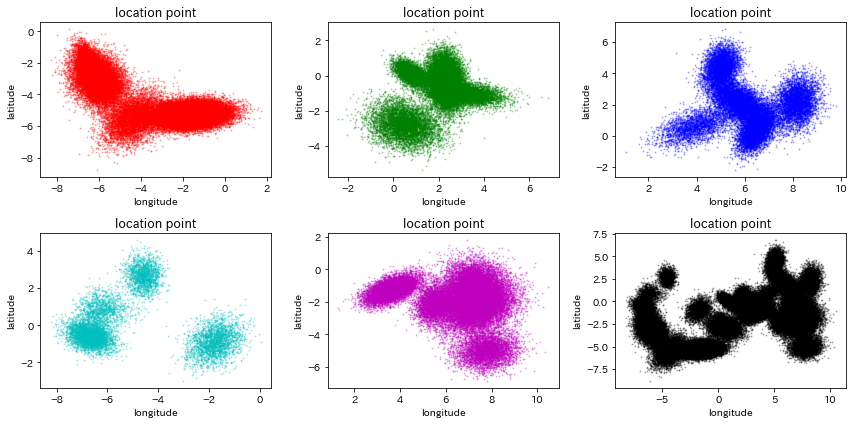

In [368]:
#locatio分布を可視化
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(k1):
    index = index_r1[j]
    ax = fig.add_subplot(2, 3, j+1)
    ax.scatter(y[index, 0], y[index, 1], s=1, c=colorlist[j], alpha=0.25, linewidths="1", edgecolors=colorlist[j])
    plt.title("location point", fontsize=12.5)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
ax = fig.add_subplot(2, 3, k1+1)
ax.scatter(y[:, 0], y[:, 1], s=1, c=colorlist[k1+1], alpha=0.25, linewidths="1", edgecolors=colorlist[k1+1])
plt.title("location point", fontsize=12.5)
plt.xlabel("longitude")
plt.ylabel("latitude")
fig.tight_layout()
plt.show()

In [369]:
#単語のインデックスを作成
wd_list = [i for i in range(v)]
for i in range(v):
    wd_list[i] = np.array(np.where(wd==i)[0], dtype="int")

In [370]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50

In [ ]:
##事前分布の設定
#nCRFの事前分布